# A2.2 Árboles de decisión

#### La clasificación se hace en los modelos de la siguente forma tomando en cuanta el valor de PM2.5: Low (menos de 10), Medium (entre 10 y 20), High (20 y 30) y Very High (más de 30).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

#### 1. Importación de los datos al ambiente de trabajo. Igualmente que en A2.1 y P1, se aplican el mismo proceso de filtración, separación en dos columnas para fecha y hora, así como la selección de características, y la aplicación del método Tukey para permanecer con los datos que son estadísticamente relevantes.

In [ ]:
data = pd.read_excel("SOLICITUD_289-24_septiembre.xlsx")

In [10]:
data_filled = data.apply(lambda x: x.fillna(x.mean()), axis=0)
nan_percentage = data_filled.isna().mean() * 100
data_filled['Fecha y hora'] = pd.to_datetime(data_filled['Fecha y hora'], format='%m/%d/%Y %I:%M:%S %p')
data_filled['Fecha'] = data_filled['Fecha y hora'].dt.date
data_filled['Hora'] = data_filled['Fecha y hora'].dt.time
reference_date = pd.to_datetime('2021-01-01')
data_filled['Fecha'] = (pd.to_datetime(data_filled['Fecha']) - reference_date).dt.days
# Convertir la columna 'Hora' en una variable cuantitativa (número de minutos desde la medianoche)
data_filled['Hora'] = data_filled['Fecha y hora'].dt.hour * 60 + data_filled['Fecha y hora'].dt.minute
# Eliminar la columna original 'Fecha y hora'
data_filled = data_filled.drop(columns=['Fecha y hora'])

# Eliminación de variables con alta colinealidad
data_filled = data_filled.drop(columns=['NO (ppb)', 'NOx (ppb) '])

# Método Tukey
def tukey_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_b = Q1 - 1.5 * IQR
    upper_b = Q3 + 1.5 * IQR
    return lower_b, upper_b

for column in data_filled.columns:
    if data_filled[column].dtype in ['int64', 'float64']:
        lower_b, upper_b = tukey_outliers(data_filled[column])
        
        # Identify outliers
        outliers = data_filled[(data_filled[column] < lower_b) | (data_filled[column] > upper_b)]

data_filled = data_filled[data_filled['CO (ppm)'] <= 30]

features = ['CO (ppm)', 'NO2 (ppb)', 'O3 (ppb)', 'PM10 (µg/m3)', 'PRS (mmHg)', 
            'RAINF (mm/h)', 'RH (%)', 'SO2 (ppb)', 'SR (kWh/m2)', 'Temp (°C)', 
            'WSR (km/h)', 'WDR (°)', 'Fecha', 'Hora']

#### Para asegurar que cada clase tenga suficientes muestras para el entrenamiento, se define un umbral mínimo de observaciones por clase (min_samples). Se eliminan las clases que tienen menos observaciones que este umbral, evitando problemas de desequilibrio extremo en el modelo.

In [16]:
min_samples = 2  # Adjust this based on dataset size
valid_classes = y.value_counts()[y.value_counts() >= min_samples].index
data_filtered = data_filled[data_filled['PM2,5 (µg/m3)'].isin(valid_classes)]

X = data_filtered[features]
y = data_filtered['PM2,5 (µg/m3)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("Test set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
17.485966    0.152099
8.000000     0.004230
15.000000    0.004230
14.000000    0.004092
6.000000     0.003908
               ...   
35.810000    0.000046
29.840000    0.000046
28.200000    0.000046
35.580000    0.000046
61.850000    0.000046
Name: PM2,5 (µg/m3), Length: 3300, dtype: float64
Test set class distribution:
17.485966    0.152130
15.000000    0.004291
8.000000     0.004184
14.000000    0.004077
16.000000    0.003862
               ...   
25.920000    0.000107
36.970000    0.000107
12.740000    0.000107
28.560000    0.000107
31.780000    0.000107
Name: PM2,5 (µg/m3), Length: 3300, dtype: float64


In [61]:
# Conteo de clases en el dataset de entrenamiento
print(y_train.value_counts())

# Mostrar en porcentaje
print(y_train.value_counts(normalize=True) * 100)


17.485966    3308
8.000000       92
15.000000      92
14.000000      89
6.000000       85
             ... 
35.810000       1
29.840000       1
28.200000       1
35.580000       1
61.850000       1
Name: PM2,5 (µg/m3), Length: 3300, dtype: int64
17.485966    15.209895
8.000000      0.423008
15.000000     0.423008
14.000000     0.409214
6.000000      0.390823
               ...    
35.810000     0.004598
29.840000     0.004598
28.200000     0.004598
35.580000     0.004598
61.850000     0.004598
Name: PM2,5 (µg/m3), Length: 3300, dtype: float64


#### 2. Se hace una regresión logística con la función Generalized Linear Model (GLM), se consideran todas las variables seleccionadas por el método de selección como predictores. Se imprimirán los resultados como un resumen estadístico, para después seleccionar las dos variables más significativas usando los valores p más pequeños. 

In [18]:
X_train_const = sm.add_constant(X_train)  # Adding constant term for statsmodels
glm_model = sm.GLM(y_train, X_train_const, family=sm.families.Binomial()).fit()
print(glm_model.summary())

# Selecting the two most relevant variables (excluding 'const')
top_vars = [var for var in glm_model.pvalues.nsmallest(3).index.tolist() if var != 'const']
X_train_reduced = X_train[top_vars]
X_test_reduced = X_test[top_vars]

                 Generalized Linear Model Regression Results                  
Dep. Variable:          PM2,5 (µg/m3)   No. Observations:                21749
Model:                            GLM   Df Residuals:                    21734
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 31 Mar 2025   Deviance:                   2.6237e+07
Time:                        19:16:52   Pearson chi2:                 2.95e+22
No. Iterations:                     2   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9.795e+17   1.05e+08   9.32e+09   

c:\Users\J_Hum\miniconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\J_Hum\miniconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1057: RuntimeWarning: invalid value encountered in log
  n * np.log(1 - mu + 1e-20)) * var_weights


#### 3. Se crea un modelo LDA, usando los datos filtrados de los pasos anteriores. Se grafica la función del discriminante para visualizar la distinción entre clases, las cuales se diferencian a través de sus colores.

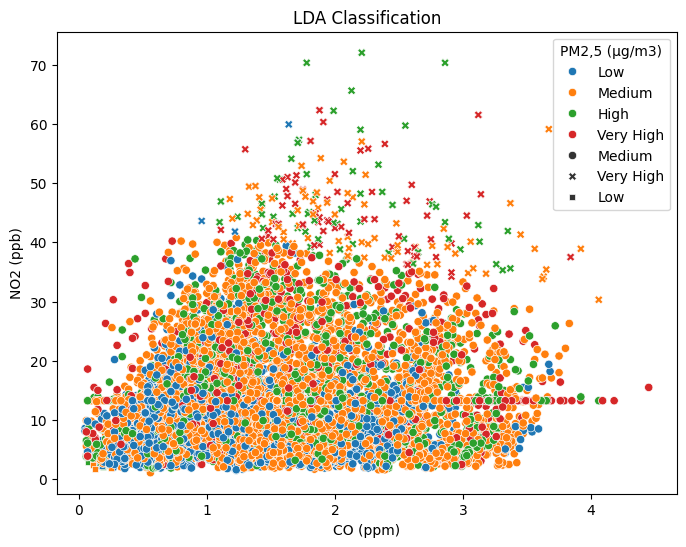

In [ ]:
# Discretize the target variable into bins
bins = [y_train.min() - 1, 10, 20, 30, y_train.max() + 1]  # Define bins
labels = ['Low', 'Medium', 'High', 'Very High']  # Define labels for bins
y_train_binned = pd.cut(y_train, bins=bins, labels=labels)
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_reduced, y_train_binned)
y_pred_lda = lda.predict(X_test_reduced)

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_reduced[top_vars[0]], y=X_test_reduced[top_vars[1]], hue=y_test_binned, style=y_pred_lda)
plt.xlabel(top_vars[0])
plt.ylabel(top_vars[1])
plt.title("LDA Classification")
plt.show()

#### 4. Se entrena un árbol de decisión inicial y se obtiene la ruta de poda a través del cost-complexity pruning path, el cual proporciona una serie de valores de α y sus respectivas impurezas. Posteriormente, se selecciona el valor óptimo de α que permite reducir significativamente la cantidad de nodos sin afectar drásticamente el desempeño del modelo. Para visualizar el impacto de la poda, se genera una gráfica que muestra la relación entre el número de nodos y el valor de α. Finalmente, se entrena un árbol podado con el mejor valor de α encontrado, y se visualiza tanto su estructura como la partición del espacio en función de dos variables.

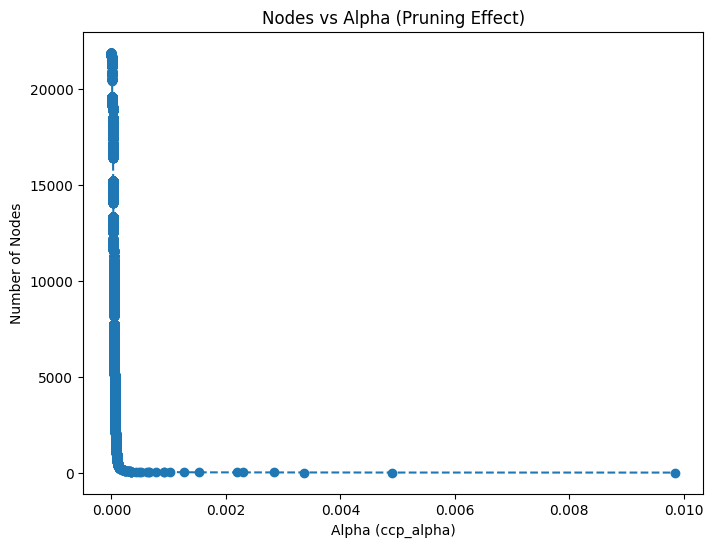

In [ ]:
from sklearn.model_selection import cross_val_score

# Entrenamiento del árbol inicial.
tree = DecisionTreeClassifier()
tree.fit(X_train_reduced, y_train_binned)

# Pruning path (alpha ccp e impurezas correspondientes)
path = tree.cost_complexity_pruning_path(X_train_reduced, y_train_binned)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#  Filtro de valores ccp_alpha (>= 0)
ccp_alphas = ccp_alphas[ccp_alphas >= 0]

# Número de nodos contra valores ccp_alpha
node_counts = []
for alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(ccp_alpha=alpha)
    pruned_tree.fit(X_train_reduced, y_train_binned)
    node_counts.append(pruned_tree.tree_.node_count)

plt.figure(figsize=(8, 6))
plt.plot(ccp_alphas, node_counts, marker="o", linestyle="--")
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Number of Nodes")
plt.title("Nodes vs Alpha (Pruning Effect)")
plt.show()

In [ ]:
best_alpha = ccp_alphas[np.argmin(np.abs(np.array(node_counts) - 100))] 

tree = DecisionTreeClassifier(ccp_alpha=best_alpha, class_weight="balanced")
tree.fit(X_train_reduced, y_train_binned)

print(f"Number of nodes in the final pruned tree: {tree.tree_.node_count}")

y_pred_tree = tree.predict(X_test_reduced)


Number of nodes in the final pruned tree: 239


In [56]:
# Plot final pruned tree
plt.figure(figsize=(200, 56))
plot_tree(tree, filled=True, feature_names=top_vars, class_names=np.unique(y).astype(str),fontsize=10)
plt.title("Árbol de Decisión Podado")
plt.show()

c:\Users\J_Hum\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


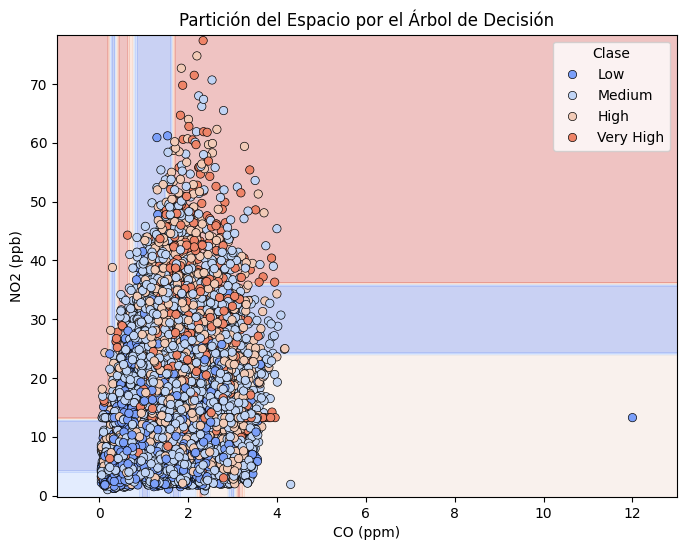

In [46]:
# Visualizar la partición en el espacio
x_min, x_max = X_train_reduced.iloc[:, 0].min() - 1, X_train_reduced.iloc[:, 0].max() + 1
y_min, y_max = X_train_reduced.iloc[:, 1].min() - 1, X_train_reduced.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

from sklearn.preprocessing import LabelEncoder

# Encode the categorical predictions into numerical values
label_encoder = LabelEncoder()
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z_encoded = label_encoder.fit_transform(Z)  # Encode predictions
Z_encoded = Z_encoded.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_encoded, alpha=0.3, cmap="coolwarm")
sns.scatterplot(x=X_train_reduced.iloc[:, 0], y=X_train_reduced.iloc[:, 1], hue=y_train_binned, palette="coolwarm", edgecolor="k")

plt.xlabel(top_vars[0])
plt.ylabel(top_vars[1])
plt.title("Partición del Espacio por el Árbol de Decisión")
plt.legend(title="Clase")
plt.show()

#### 5. Finalmente, se imprimen las métricas como la matriz de confusión y un reporte de clasificación con el objetivo de comparar los modelos LDA y el árbol de decisión.

In [60]:
print("LDA Classification Report:")
print(classification_report(y_test_binned, y_pred_lda))
print("Decision Tree Classification Report:")
print(classification_report(y_test_binned, y_pred_tree))

print("Confusion Matrix for LDA:")
print(confusion_matrix(y_test_binned, y_pred_lda))
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test_binned, y_pred_tree))

LDA Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00      1577
         Low       0.42      0.00      0.00      2148
      Medium       0.52      0.98      0.68      4819
   Very High       0.33      0.08      0.13       777

    accuracy                           0.52      9321
   macro avg       0.32      0.27      0.21      9321
weighted avg       0.39      0.52      0.36      9321

Decision Tree Classification Report:


c:\Users\J_Hum\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\J_Hum\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\J_Hum\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        High       0.25      0.34      0.29      1577
         Low       0.38      0.60      0.46      2148
      Medium       0.65      0.23      0.34      4819
   Very High       0.20      0.53      0.29       777

    accuracy                           0.36      9321
   macro avg       0.37      0.42      0.34      9321
weighted avg       0.48      0.36      0.36      9321

Confusion Matrix for LDA:
[[   0    2 1519   56]
 [   0    5 2139    4]
 [   0    4 4740   75]
 [   0    1  710   66]]
Confusion Matrix for Decision Tree:
[[ 529  353  246  449]
 [ 350 1291  283  224]
 [1044 1667 1112  996]
 [ 186   99   81  411]]


#### Para determinar cual modelo ofrece una mejor capacidad de clasificación, se deben evaluar las métricas de exactitud (accuracy), F1-score y la matriz de confusión. LDA  presenta una exactitud de 52%, y el árbol de decisión tiene 36%. Mientras que el árbol de decisión cuenta con mejor precisión (0.48 mejor que 0.39), en F1-score ambos modelos tienes valores iguales. Por lo tanto, al saber que nuestro conjunto de datos está desbalanceado, es importante darle mayor peso al F1-score y la precisión, los cuales nos indican que el modelo que cuenta con menos falsos positivos es el árbol de decisiones.